# Dunnhumby dataset

In [193]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import Image

We load our dataset.

In [194]:
product = pd.read_csv('data/product.csv')
coupon = pd.read_csv('data/coupon.csv')
coupon = coupon.drop_duplicates(keep='first')
campaign = pd.read_csv('data/campaign_desc.csv')
trans = pd.read_csv('data/transaction_data.csv')
demographic = pd.read_csv('data/hh_demographic.csv')
campaign_table = pd.read_csv('data/campaign_table.csv')
coupon_redemption = pd.read_csv('data/coupon_redempt.csv')

Our dataset is composed of several tables:
* __product__ : This table contains information on each product sold such as type of product, department, brand identifier.


* __trans__ : This table contains all products purchased by households within this study.


* __demographic__ : This table contains demographic information for a portion of households, like the marital status, age description, household composition. 


* __campaign__ : This table lists the campaigns received by each household in the study. 


* __campaign_table__ : This table gives the length of time for which a campaign runs. So, any coupons received as part of a campaign are valid within the dates contained in this table.


* __coupon__ : This table lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable. 


* __coupon_redemption__: This table identifies the coupons that each household redeemed.

The following table is taken from the documentation of the dataset, which describes the relationships of the various dataframes described above.

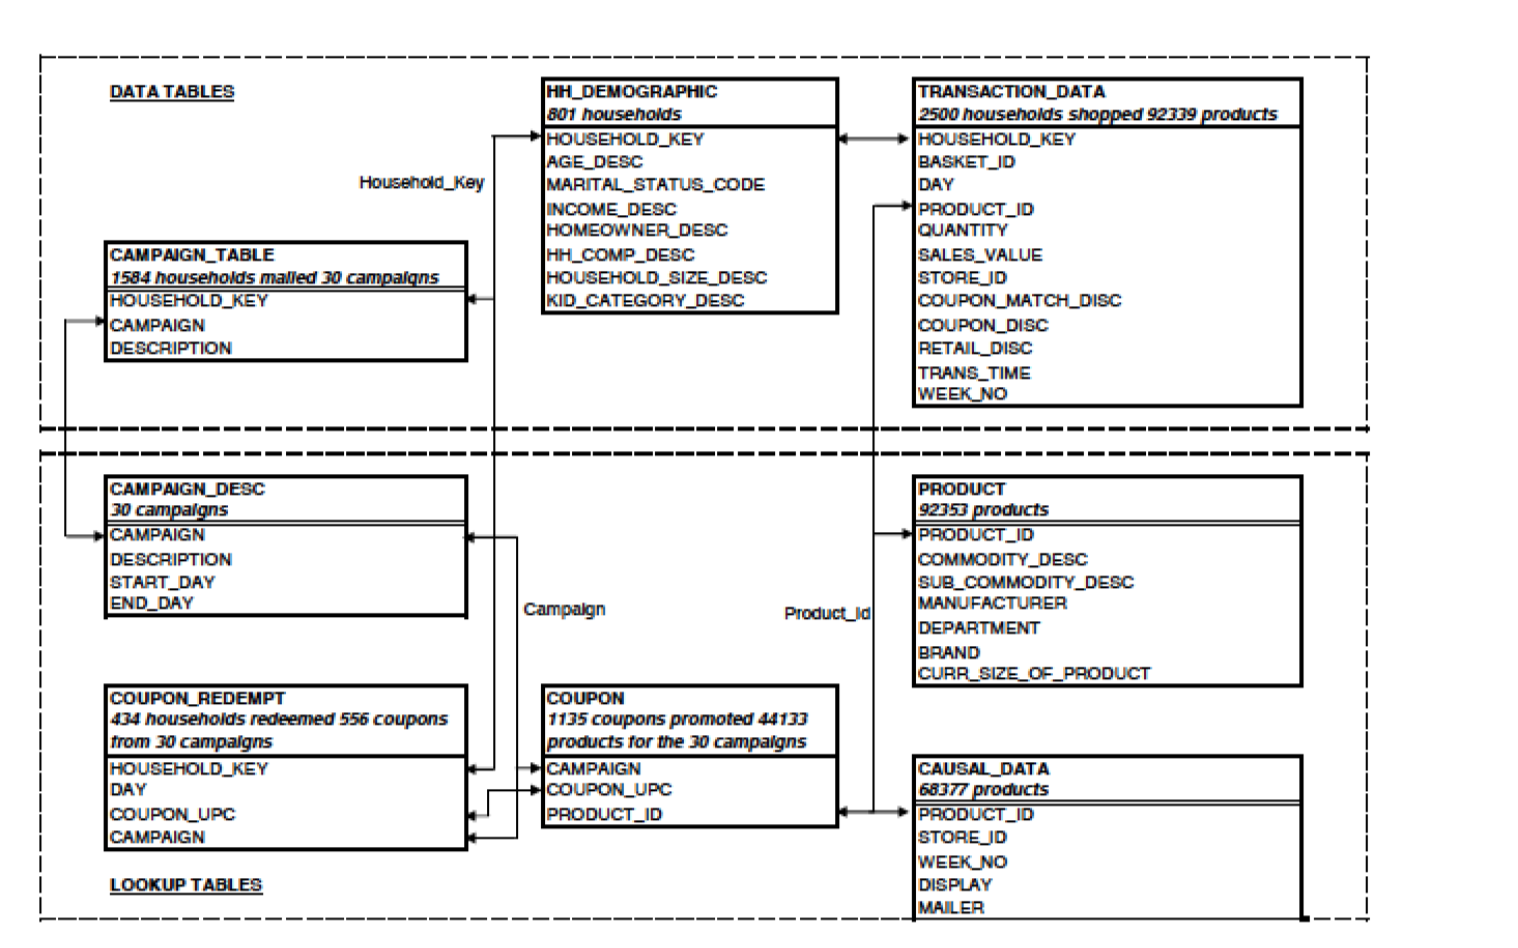

In [195]:
Image('./data/tables.png', width=800,height=600)

# 1. Exploration on our dataset

We start with a general exploration of our dataset.

## A. Demographic distribution

First, we will concentrate in analyzing the demographic distribution of the families who provided their demographical infomations.

In [196]:
demographic.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


First, we note there are 2 non-numerical columns that contains range, therefore we expand them so that we will able to easily split family in our analysis based on some income/age characteristic.

In [197]:
age_levels = demographic['AGE_DESC'].drop_duplicates().to_frame()
age_levels['MIN_AGE'] = age_levels['AGE_DESC'].apply(lambda x : int(x[:2]))
age_levels = age_levels.set_index('AGE_DESC')

In [198]:
age_levels

,MIN_AGE
AGE_DESC,
65+,65
45-54,45
25-34,25
35-44,35
19-24,19
55-64,55


In [199]:
demographic['MIN_AGE'] = demographic['AGE_DESC'].apply(lambda x: age_levels.loc[x])

Also, we plot the age distribution for those families.

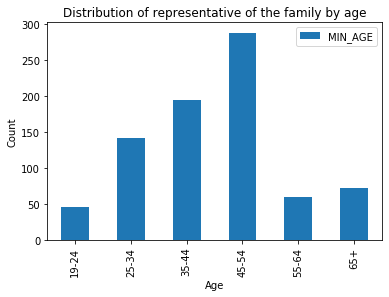

In [200]:
demographic.groupby('AGE_DESC')[['MIN_AGE']].count().plot.bar()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of representative of the family by age')
plt.show()

Then, we repeat the same operation for the incomes.

In [201]:
income_levels = demographic['INCOME_DESC'].drop_duplicates().to_frame()
min_income = lambda x: 0 if x.startswith('U') else int(x[:x.find('-') if '-' in x else 3])
max_income = lambda x: 250 if x.endswith('+') else int(x[max(x.find(' '), x.find('-')) + 1:x.find('K')]) # Maxincome for 250K+ ??
income_levels['MIN_INCOME'] = income_levels['INCOME_DESC'].apply(lambda x : min_income(x))
income_levels['MAX_INCOME'] = income_levels['INCOME_DESC'].apply(lambda x : max_income(x))
income_levels = income_levels.set_index('INCOME_DESC')
income_levels

,MIN_INCOME,MAX_INCOME
INCOME_DESC,,
35-49K,35,49
50-74K,50,74
25-34K,25,34
75-99K,75,99
Under 15K,0,15
100-124K,100,124
15-24K,15,24
125-149K,125,149
150-174K,150,174


In [202]:
demographic[['MIN_INCOME', 'MAX_INCOME']] = demographic['INCOME_DESC'].apply(lambda x: income_levels.loc[x])

In [203]:
income_plot = income_levels[['MIN_INCOME']].copy()
income_plot['INCOME_DESC'] = demographic['INCOME_DESC'].value_counts()

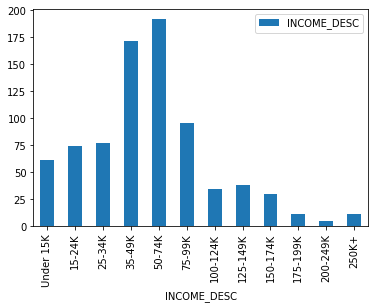

In [204]:
income_plot.sort_values(by='MIN_INCOME')[['INCOME_DESC']].plot.bar()

Again, here we plotted the distribution of the incomes for the families who decided to provide those information.

## B. Transaction history

Now, we take a closer look to the transactions we have.

In [205]:
def plot_weekly_avg_sales(trans):
    
    avg_sales = trans.groupby('WEEK_NO')['SALES_VALUE'].sum().apply(lambda x: x/7)
    
    avg_sales.plot()
    plt.xlabel('Week number')
    plt.ylabel('Average sales by day [$]')
    plt.title('Evolution of the average sales through the weeks')

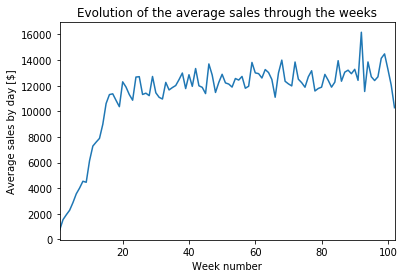

In [206]:
plot_weekly_avg_sales(trans)

We notice that the average sales by day increase very fast during the first 20 weeks which seems odd. This could be because not all households have signed up for the survey yet, so their transaction history isn't being recorded yet.

Let's test this hypothesis. For each household, we find out the day in which they did their first transaction. While we're at it, let's also find out the day of their last transaction.

We plot a cumulative distribution of this first-transaction day.

In [207]:
trans_days = trans.groupby('household_key')['DAY'].min().to_frame().rename(columns={'DAY': 'FIRST DAY'})
trans_days['LAST DAY'] = trans.groupby('household_key')['DAY'].max()

[]

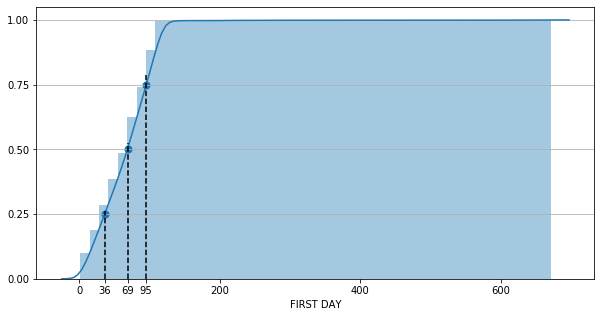

In [208]:
trans_distr = pd.DataFrame([trans_days.quantile(perc) for perc in np.arange(0.25, 1, 0.25)])
first_days_distr = trans_distr['FIRST DAY'].tolist()

fig, ax = plt.subplots(figsize=(10, 5)) 
g = sns.distplot(trans_days['FIRST DAY'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
g.set(xticks=list(range(0, 800, 200)) + first_days_distr)
g.set(yticks=np.arange(0, 1.1, 0.25))
plt.scatter(first_days_distr, trans_distr.index, marker='o', s=50)
for x,y in zip(first_days_distr, trans_distr.index):
    plt.axvline(x=x, color='k', linestyle='--', ymax=y)
ax.yaxis.grid(True)
g.plot()

It seems as if by day 100, all households have already made their first transaction.

So, we were not recording transaction history until week 20. The registration rate seems to be more or less constant, so by **day 69**, for instance, only **half the households** were recording their transactions and therefore we would expect the sales average to be **half of what it was at the end** of the survey.

We can compare the average sale per day during week 10 (~half-households) and 20 (all households).

In [209]:
print('Average sales per day during week 10: {:f} $'\
      .format(trans[trans['WEEK_NO'] == 10]['SALES_VALUE'].sum()/7))
print('Average sales per day between week 20 and the end of the survey: {:f} $'\
      .format(trans[trans['WEEK_NO'] > 20]['SALES_VALUE'].sum()/(711-20*7)))

Average sales per day during week 10: 6142.054286 $
Average sales per day between week 20 and the end of the survey: 12509.549825 $


This confirms our hypothesis. We might then only want to consider transactions that happened after week 20 so we are sure that the full household population is active.

This brings another question: did some of the households stop shopping before the end of the survey?

Let's plot the cumulative distribution of the day of the last transaction for every household.

FIRST DAY     30.0
LAST DAY     684.0
Name: 0.2, dtype: float64

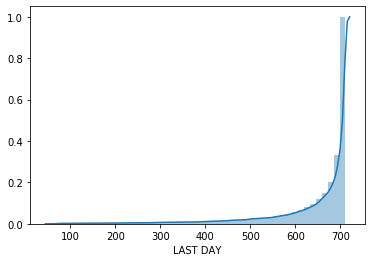

In [213]:
sns.distplot(trans_days['LAST DAY'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
trans_days.quantile(0.2)

Progressively, some of the households seem to be abandoning the survey but by day 680 (~30 days before the end of the survey) more than 80% of the houshoolds are still making transactions.

## C. Product distributions

We will analyze the products sold by department, the stores for which we have the data may be selling particular kinds of product.

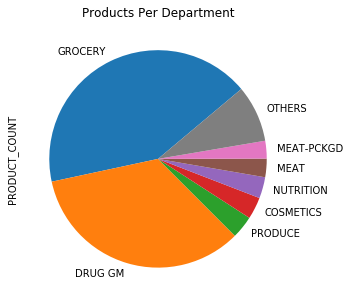

In [62]:
dept_count = product.groupby('DEPARTMENT').count().rename(columns={'MANUFACTURER':'PRODUCT_COUNT'})['PRODUCT_COUNT']
tmp = dept_count.sort_values(ascending=False).to_frame()
others_product_ct = sum(tmp[tmp['PRODUCT_COUNT']<2400]['PRODUCT_COUNT'])
tmp[tmp['PRODUCT_COUNT']>2400].reset_index().\
            append({'DEPARTMENT':'OTHERS', 'PRODUCT_COUNT':others_product_ct}, ignore_index=True).\
            set_index('DEPARTMENT').\
            plot.pie(y='PRODUCT_COUNT', figsize=(10, 5),title='Products Per Department', legend=None, startangle=40)

As seen above, the major departments are 'GROCERY' and 'DRUG GM'. Together they make up more than 2/3 of the total products.

Now, we want to see which kind of product constitutes these departments.

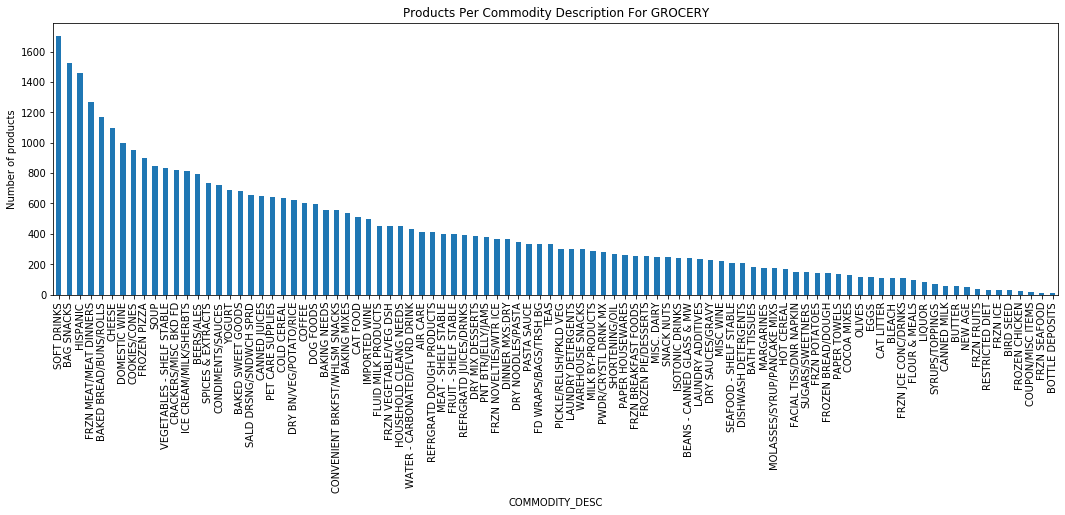

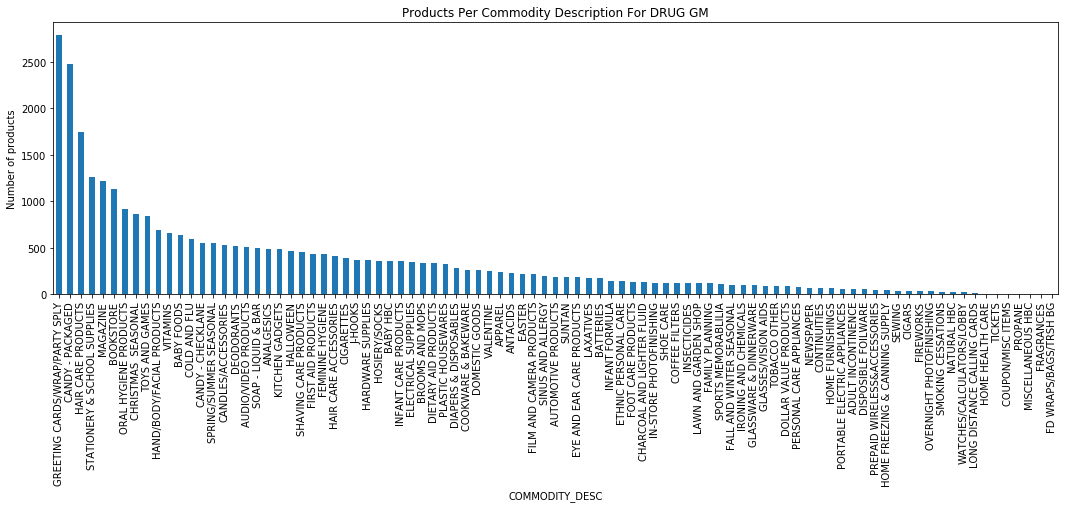

In [225]:
#Since most of the products are of the cathegory 'GROCERY' or 'DRUG GM', 
# priting the amount of products per 'COMMODITY_DESC'
best_departments = ['GROCERY', 'DRUG GM']
for dep in best_departments:
    commodity_count = product[product['DEPARTMENT']== dep].groupby('COMMODITY_DESC').count()\
    .rename(columns={'MANUFACTURER':'PRODUCT_COUNT'})['PRODUCT_COUNT']
    commodity_count.sort_values(ascending=False).plot.bar(y='PRODUCT_COUNT', figsize=(18, 5), title='Products Per Commodity Description For ' + dep)
    plt.ylabel('Number of products')
    plt.show()

## D. Coupons

We analyze the products on which the coupons are issued, and group by department to see if the distribution reflects the one in the previous section. 

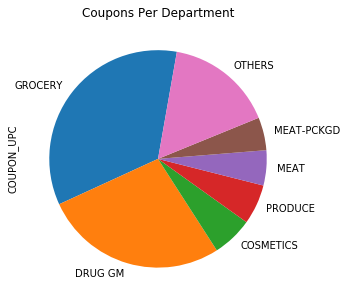

In [171]:
coupon_by_dept = coupon.groupby('PRODUCT_ID').agg('count').sort_values('COUPON_UPC', ascending=False).\
                join(product, how='left').\
                groupby('DEPARTMENT').agg('count').sort_values('COUPON_UPC', ascending=False)['COUPON_UPC'].\
                to_frame()

others_ct = sum(coupon_by_dept[coupon_by_dept['COUPON_UPC']<1000]['COUPON_UPC'])
coupon_by_dept[coupon_by_dept['COUPON_UPC']>1000].reset_index().\
            append({'DEPARTMENT':'OTHERS', 'COUPON_UPC':others_product_ct}, ignore_index=True).\
            set_index('DEPARTMENT').\
            plot.pie(y='COUPON_UPC', figsize=(10, 5),title='Coupons Per Department', legend=None, startangle=80)

We observe that 'GROCERY' and 'DRUG GM' which were the 2 major departments also have the largest number of coupon associated with them. <br>
Now we focus on the redemmed coupons. We filter out the transactions in which coupons were used.

In [238]:
products_redeemed = coupon_redemption.merge(coupon, on=['COUPON_UPC', 'CAMPAIGN'])
coupon_trans = trans[(trans['COUPON_DISC'] < 0) | (trans['COUPON_MATCH_DISC'] < 0) | (trans['RETAIL_DISC'] < 0)] \
                .merge(products_redeemed, on=['household_key', 'DAY', 'PRODUCT_ID'])

Text(0.5, 1.0, 'Discount in dollars per department')

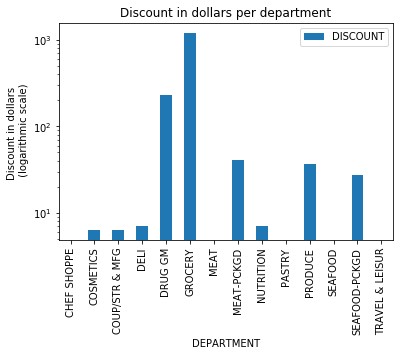

In [242]:
prod = product.reset_index()[['PRODUCT_ID', 'DEPARTMENT']].copy()
disc = coupon_trans.copy()
disc['DISCOUNT'] = -(disc['COUPON_DISC'] + disc['COUPON_MATCH_DISC'] + disc['RETAIL_DISC'])
total_disc = t.merge(prod, on='PRODUCT_ID').groupby('DEPARTMENT').sum()['DISCOUNT'].to_frame().plot.bar()
plt.yscale('log')
plt.ylabel('Discount in dollars \n (logarithmic scale)')
plt.title('Discount in dollars per department')

The above plot shows the total discount obtained by using coupons per department.

We notice that COSMETICS is one of the department with the highest number of coupon associated but issue quite a little total discount. This can be due to a low usage of coupons in this particular department or maybe because each coupon apply really little discount. 

We cannot recover exactly how many coupons are issued for each department, from the documentation of our dataset: <br>
_"For campaign TypeA, this table provides the pool of possible coupons. Each customer participating in a TypeA campaign received 16 coupons out of the pool. The 16 coupons were selected based on the customer’s prior purchase behavior. Identifying the specific 16 coupons that each customer received is outside the scope of this database."_

Therefore, we cannot verify our first hypothesis but we will try to compare the average discount for coupon per department.

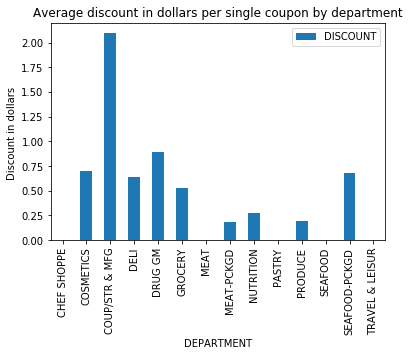

In [243]:
disc['DISCOUNT'] = -(disc['COUPON_DISC'] + disc['COUPON_MATCH_DISC']) / disc['QUANTITY']
total_disc = t.merge(prod, on='PRODUCT_ID').groupby('DEPARTMENT').mean()['DISCOUNT'].to_frame().plot.bar()
plt.title('Average discount in dollars per single coupon by department')
plt.ylabel('Discount in dollars ')
plt.show()

# Impacts of coupons

In this section we analyse the impact of coupons by considering how coupons are redeemed, for which products, and how the sales vary. We explain in detail below the factors which we consider.

In [5]:
products_redeemed = coupon_redemption.merge(coupon, on=['COUPON_UPC', 'CAMPAIGN'])

coupon_trans = trans[(trans['COUPON_DISC'] < 0) | (trans['COUPON_MATCH_DISC'] < 0) | (trans['RETAIL_DISC'] < 0)] \
                .merge(products_redeemed, on=['household_key', 'DAY', 'PRODUCT_ID'])

print('We found {} transactions where coupons were used and the COUPON REDEMPTION table had {} entries, so some coupons affected several products in one single basket.'\
     .format(coupon_trans.shape[0], coupon_redemption.shape[0]))

We found 3186 transactions where coupons were used and the COUPON REDEMPTION table had 2318 entries, so some coupons affected several products in one single basket.


We measure the impact of a coupon transaction on one household by computing several statistics such as:
- total sales before and after
- average sales before and after (per day)
- average sales difference (per day)
- predicted total sales increase *(computed as the difference between the total sales after and the predicted total sales if the average sales per day had remained the same as before)*

*Note: We take into account the fact that some families started recording their transaction history later than others in this analysis.*

In [8]:
def compute(trans, day, day_zero=0):

    trans_before = trans[trans['DAY'] < day]
    trans_after = trans[trans['DAY'] >= day]

    total_sales_before = trans_before['SALES_VALUE'].sum()
    total_sales_after = trans_after['SALES_VALUE'].sum()

    avg_sales_before = total_sales_before/(day-day_zero)
    avg_sales_after = total_sales_after/(711-day)
    avg_diff = avg_sales_after - avg_sales_before
    
    pred_total_sales_increase = total_sales_after - (711-day) * avg_sales_before

    return [total_sales_before, total_sales_after, avg_sales_before, avg_sales_after, avg_diff, pred_total_sales_increase]

In [11]:
scores = pd.DataFrame(columns=['Total sales before', 'Total sales after', 'Average sales before', 'Average sales after', \
                               'Average sales difference', 'Predicted total sales increase', \
                               'household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'])

for i, t in coupon_trans.iterrows():
    household_key = t['household_key']
    product_id = t['PRODUCT_ID']
    day = t['DAY']
    coupon_upc = t['COUPON_UPC']
    campaign_ = t['CAMPAIGN']
    day_zero = trans_days.loc[household_key]['FIRST_DAY']
    selected_trans = trans[(trans['PRODUCT_ID'] == product_id) & (trans['household_key'] == household_key)]
    scores.loc[i] = compute(selected_trans, day, day_zero) + [household_key, product_id, day, coupon_upc, campaign_]

scores = scores.astype({'household_key': 'int64', 'PRODUCT_ID': 'int64', 'DAY': 'int64', 'COUPON_UPC': 'int64', 'CAMPAIGN': 'int64'})
#scores.set_index(['household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'], inplace=True)

scores.head()

,Total sales before,Total sales after,Average sales before,Average sales after,Average sales difference,Predicted total sales increase,household_key,PRODUCT_ID,DAY,COUPON_UPC,CAMPAIGN
0,14.26,3.24,0.081954,0.006667,-0.075287,-36.589655,2280,1139915,225,57008510075,26
1,0.00,2.69,0.000000,0.005546,0.005546,2.690000,2240,6039659,226,53600000001,26
2,6.67,3.34,0.040671,0.006901,-0.033770,-16.344634,788,895680,227,57218020076,26
3,0.00,3.48,0.000000,0.007190,0.007190,3.480000,788,899736,227,55100055008,26
4,0.00,1.74,0.000000,0.003595,0.003595,1.740000,788,954495,227,55100055008,26


# Campaign success

Let's sum the predicted total sales increase by campaign so we can get an idea of how succesful each campaign was. 

In [575]:
scores.groupby('CAMPAIGN')[['Predicted total sales increase']].sum() \
.sort_values('Predicted total sales increase', ascending=False)

,Predicted total sales increase
CAMPAIGN,
18,4097.444923
13,3068.408493
8,2146.053370
9,296.547034
23,269.245123
30,264.074029
19,260.298886
25,200.215435
22,191.582775


Campaigns 18, 13 and 8 really stand out. Because the statistic used for comparison takes the total sales after the coupon was used, it might be that these campaigns took place earlier than the rest which would explain this big gap.

We also notice that some of the campaigns have a negative predicted total sales increase, but this wouldn't be particularly alarming because it could be due to some seasonal effect.

[Text(0, 0.5, 'Campaign predicted total sales increase [$]'),
 Text(0.5, 0, 'First day of the campaign'),
 Text(0.5, 1.0, 'Predicted total sales increase vs. start day of the campaign')]

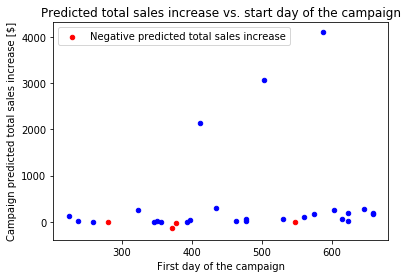

In [12]:
fig, ax = plt.subplots()

tmp = scores.groupby('CAMPAIGN')[['Predicted total sales increase']].sum() \
      .merge(campaign, left_index=True, right_on='CAMPAIGN')

tmp_pos = tmp[tmp['Predicted total sales increase'] > 0]
tmp_neg = tmp[tmp['Predicted total sales increase'] < 0]

tmp_pos.plot.scatter(x='START_DAY', y='Predicted total sales increase', marker='o', c='b', ax=ax)
tmp_neg.plot.scatter(x='START_DAY', y='Predicted total sales increase', marker='o', c='r', ax=ax, label='Negative predicted total sales increase')

ax.set(ylabel='Campaign predicted total sales increase [$]', xlabel='First day of the campaign', title='Predicted total sales increase vs. start day of the campaign')

In [15]:
scores = pd.DataFrame(columns=['Total sales before', 'Total sales after', 'Average sales before', 'Average sales after', \
                               'Average sales difference', 'Predicted total sales increase', \
                               'household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'])

for i, t in coupon_trans.iterrows():
    household_key = t['household_key']
    product_id = t['PRODUCT_ID']
    day = t['DAY']
    coupon_upc = t['COUPON_UPC']
    campaign_ = t['CAMPAIGN']
    day_zero = trans_days.loc[household_key]['FIRST_DAY']
    selected_trans = trans[(trans['PRODUCT_ID'] == product_id) & (trans['household_key'] == household_key)]
    scores.loc[i] = compute(selected_trans, day, day_zero) + [household_key, product_id, day, coupon_upc, campaign_]

scores = scores.astype({'household_key': 'int64', 'PRODUCT_ID': 'int64', 'DAY': 'int64', 'COUPON_UPC': 'int64', 'CAMPAIGN': 'int64'})
#scores.set_index(['household_key', 'PRODUCT_ID', 'DAY', 'COUPON_UPC', 'CAMPAIGN'], inplace=True)


The top campaigns seem to be distributed over time, so this isn't a determining factor.

We can now try to understand what made this campaigns so successful. For that, we will start by looking at the category to which the items bought during these 3 top campaigns belong.

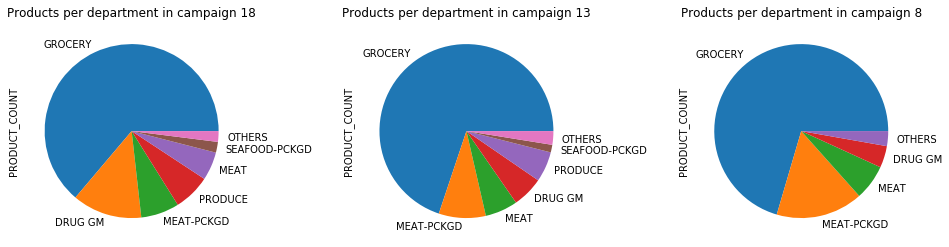

In [557]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

tmp = coupon_trans[coupon_trans['CAMPAIGN'] == 18][['PRODUCT_ID']] \
      .merge(product, on='PRODUCT_ID').drop_duplicates() \
      .groupby('DEPARTMENT').count().rename(columns={'PRODUCT_ID': 'PRODUCT_COUNT'})[['PRODUCT_COUNT']] \
      .sort_values('PRODUCT_COUNT', ascending=False)
# Group departments with PRODUCT_COUNT < 10 as 'OTHERS'
others_count = sum(tmp[tmp['PRODUCT_COUNT'] < 10]['PRODUCT_COUNT'])
tmp = tmp[tmp['PRODUCT_COUNT']>=10]
tmp.loc['OTHERS'] = others_count
tmp.plot.pie(y = 'PRODUCT_COUNT', ax=ax1, title='Products per department in campaign 18', legend=None)

tmp = coupon_trans[coupon_trans['CAMPAIGN'] == 13][['PRODUCT_ID']] \
      .merge(product, on='PRODUCT_ID').drop_duplicates() \
      .groupby('DEPARTMENT').count().rename(columns={'PRODUCT_ID': 'PRODUCT_COUNT'})[['PRODUCT_COUNT']] \
      .sort_values('PRODUCT_COUNT', ascending=False)
# Group departments with PRODUCT_COUNT < 10 as 'OTHERS'
others_count = sum(tmp[tmp['PRODUCT_COUNT'] < 10]['PRODUCT_COUNT'])
tmp = tmp[tmp['PRODUCT_COUNT']>=10]
tmp.loc['OTHERS'] = others_count
tmp.plot.pie(y = 'PRODUCT_COUNT', ax=ax2, title='Products per department in campaign 13', legend=None)

tmp = coupon_trans[coupon_trans['CAMPAIGN'] == 8][['PRODUCT_ID']] \
      .merge(product, on='PRODUCT_ID').drop_duplicates() \
      .groupby('DEPARTMENT').count().rename(columns={'PRODUCT_ID': 'PRODUCT_COUNT'})[['PRODUCT_COUNT']] \
      .sort_values('PRODUCT_COUNT', ascending=False)
# Group departments with PRODUCT_COUNT < 10 as 'OTHERS'
others_count = sum(tmp[tmp['PRODUCT_COUNT'] < 10]['PRODUCT_COUNT'])
tmp = tmp[tmp['PRODUCT_COUNT']>=10]
tmp.loc['OTHERS'] = others_count
tmp.plot.pie(y = 'PRODUCT_COUNT', ax=ax3, title='Products per department in campaign 8', legend=None)

The distribution across departments seems to be dominated by `GROCERY`, followed by `MEAT-PCKGD`, but this also similar to the distribution of products across departments for the whole set of products.

We can now try to visualize how the `Predicted total sales increase` is distributed between departments.

In [14]:
scores.columns

Index(['Total sales before', 'Total sales after', 'Average sales before',
       'Average sales after', 'Average sales difference',
       'Predicted total sales increase', 'household_key', 'PRODUCT_ID', 'DAY',
       'COUPON_UPC', 'CAMPAIGN'],
      dtype='object')

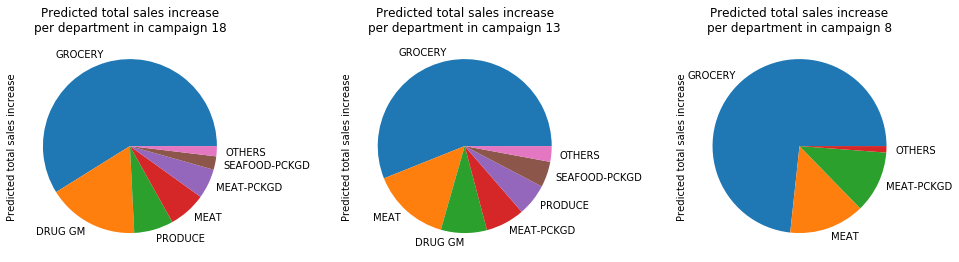

In [569]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))

tmp = scores[scores['CAMPAIGN'] == 18] \
      .merge(product, on='PRODUCT_ID') \
      .groupby('DEPARTMENT').sum()[['Predicted total sales increase']] \
      .sort_values('Predicted total sales increase', ascending=False)
# Group departments with 'Predicted total sales increase' < 100 as 'OTHERS'
others_value = sum(tmp[tmp['Predicted total sales increase'] < 100]['Predicted total sales increase'])
tmp = tmp[tmp['Predicted total sales increase']>=100]
tmp.loc['OTHERS'] = others_value
tmp.plot.pie(y = 'Predicted total sales increase', ax=ax1, title='Predicted total sales increase\nper department in campaign 18', legend=None)

tmp = scores[scores['CAMPAIGN'] == 13] \
      .merge(product, on='PRODUCT_ID') \
      .groupby('DEPARTMENT').sum()[['Predicted total sales increase']] \
      .sort_values('Predicted total sales increase', ascending=False)
# Group departments with 'Predicted total sales increase' < 100 as 'OTHERS'
others_value = sum(tmp[tmp['Predicted total sales increase'] < 100]['Predicted total sales increase'])
tmp = tmp[tmp['Predicted total sales increase']>=100]
tmp.loc['OTHERS'] = others_value
tmp.plot.pie(y = 'Predicted total sales increase', ax=ax2, title='Predicted total sales increase\nper department in campaign 13', legend=None)

tmp = scores[scores['CAMPAIGN'] == 8] \
      .merge(product, on='PRODUCT_ID') \
      .groupby('DEPARTMENT').sum()[['Predicted total sales increase']] \
      .sort_values('Predicted total sales increase', ascending=False)
# Group departments with 'Predicted total sales increase' < 100 as 'OTHERS'
others_value = sum(tmp[tmp['Predicted total sales increase'] < 100]['Predicted total sales increase'])
tmp = tmp[tmp['Predicted total sales increase']>=100]
tmp.loc['OTHERS'] = others_value
tmp.plot.pie(y = 'Predicted total sales increase', ax=ax3, title='Predicted total sales increase\nper department in campaign 8', legend=None)